In [1]:
print("meowmeow")

print("hello?")

print("hehehaha")

meowmeow
hello?
hehehaha


In [3]:
print("kaiyi test")

print("weeeeeee")
print("weyuwuye")

kaiyi test
weeeeeee
weyuwuye


In [1]:
import cv2 # Will be used for edge detection further on
import os 
import numpy as np  # For numerical operations
from PIL import Image, ImageEnhance  # For image loading and augmentation
import matplotlib.pyplot as plt  # For visualization
from sklearn.preprocessing import LabelEncoder  # For encoding labels
import random  # For random transformations


Hello from the right kernel!


In [2]:
from PIL import Image, ImageEnhance, ImageFilter


# Set Parameters
target_size = (224, 224)  # Standard input size for CNN
rotation_prob = 0.4  # 40% chance of rotation
saturation_prob = 0.5  # 50% chance of saturation change
min_saturation = 0.7  # Min saturation level
max_saturation = 1.3  # Max saturation level
blur_prob = 0.5  # 50% chance of blur
noise_prob = 0.5  # 50% chance of noise
min_crop_size = (70, 70)  # Minimum size of crop to avoid cutting off too much
padding = 80  # Padding to avoid cutting off important parts of the image
border_threshold = 5 # For the black border threshold count

# To crop out the edges
def auto_crop(img, padding=5, min_crop_size=(70, 70)):
    """
    Crops the image to the largest contour found using Canny edge detection.
    Returns the original image if no valid contour is found.
    """
    if isinstance(img, Image.Image):
        img_cv = np.array(img)
    else:
        img_cv = img.copy()

    gray = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, threshold1=50, threshold2=100)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if cv2.contourArea(c) > 300]  # slightly more relaxed

    if contours:
        # Use the largest contour
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        x = max(0, x - padding)
        y = max(0, y - padding)
        x_end = min(img.width, x + w + 2 * padding)
        y_end = min(img.height, y + h + 2 * padding)

        cropped = img.crop((x, y, x_end, y_end))
        
        # Only return cropped if it still has valid size
        if cropped.size[0] >= min_crop_size[0] and cropped.size[1] >= min_crop_size[1]:
            return cropped

    return img  # fallback: return original image if crop fails



# Function to resize image
def resize_image(img, target_size=(224, 224)):
    return img.resize(target_size, Image.LANCZOS)


# Function to apply random blur to an image
def apply_random_blur(img, prob=0.5):
    if random.random() < prob:
        radius = random.uniform(0.1, 2.0)  # Random blur radius
        return img.filter(ImageFilter.GaussianBlur(radius))
    return img  # No blur

# Function to add random noise to an image
def add_random_noise(img, prob=0.5):
    if random.random() < prob:
        img_array = np.array(img)
        noise = np.random.normal(0, 0.1, img_array.shape)  # Add Gaussian noise
        noisy_img_array = img_array + noise * 255  # Scale noise
        noisy_img_array = np.clip(noisy_img_array, 0, 255).astype(np.uint8)  # Ensure values are valid
        return Image.fromarray(noisy_img_array)
    return img  # No noise

# Function to adjust saturation
def adjust_saturation(img, min_factor=0.7, max_factor=1.3, prob=0.5):
    if random.random() < prob:
        factor = random.uniform(min_factor, max_factor)
        enhancer = ImageEnhance.Color(img)
        return enhancer.enhance(factor)
    return img  # No change


def rotate_image(img, max_angle=10, rotation_prob=0.4):
    """Random rotation with proper border handling"""
    if random.random() < rotation_prob:
        angle = random.uniform(-max_angle, max_angle)
        
        # Rotate on expanded canvas
        rotated = img.rotate(angle, expand=True, resample=Image.BILINEAR)
        
        # Convert to numpy array for border detection
        np_img = np.array(rotated)
        
        if np_img.ndim == 3:  # Color image
            # Find non-black pixels (any channel > threshold)
            non_black = np.any(np_img > border_threshold, axis=2)
        else:  # Grayscale
            non_black = np_img > border_threshold
            
        if np.any(non_black):
            # Get bounding box coordinates
            rows = np.any(non_black, axis=1)
            cols = np.any(non_black, axis=0)
            y_min, y_max = np.where(rows)[0][[0, -1]]
            x_min, x_max = np.where(cols)[0][[0, -1]]
            
            # Crop and convert back to PIL
            cropped = rotated.crop((x_min, y_min, x_max, y_max))
            return cropped.resize(target_size, Image.LANCZOS)
    
    # Return original if no rotation or if border removal failed
    return img.resize(target_size, Image.LANCZOS) if rotation_prob else img

# Function to adjust brightness
def adjust_brightness(img, min_factor=1.1, max_factor=1.5, prob=0.5):
    if random.random() < prob:
        factor = random.uniform(min_factor, max_factor)
        enhancer = ImageEnhance.Brightness(img)
        return enhancer.enhance(factor)
    return img  # No change





In [3]:
train_folder = "Train"  # Change to your dataset path
train_images = []
train_labels = []

for img_file in os.listdir(train_folder):
    if img_file.endswith(".png"):
        img_path = os.path.join(train_folder, img_file)

        # Load image using PIL
        img = Image.open(img_path).convert("RGB")

        # Extract class label from filename
        class_label = int(img_file.split("__")[0])

        # Apply preprocessing
        img = rotate_image(img, max_angle=10, rotation_prob=rotation_prob)  # Selective Rotation
        img = auto_crop(img)  # Crop after rotation
        img = adjust_brightness(img, prob=0.5) # adjust the brightness of images if they are darkened
        img = adjust_saturation(img, min_factor=min_saturation, max_factor=max_saturation, prob=saturation_prob)  # Selective Saturation
        img = apply_random_blur(img, prob=blur_prob)  # Random image blurring
        img = add_random_noise(img, prob=noise_prob)  # Apply random noise to some images
        img = resize_image(img, target_size)  # Resize after all transformations
        
        
        # Convert image to NumPy array and normalize
        img = np.array(img) / 255.0  

        # Store processed image and label
        train_images.append(img)
        train_labels.append(class_label)

# Convert to NumPy arrays
X_train = np.array(train_images)
y_train = np.array(train_labels)
 
 


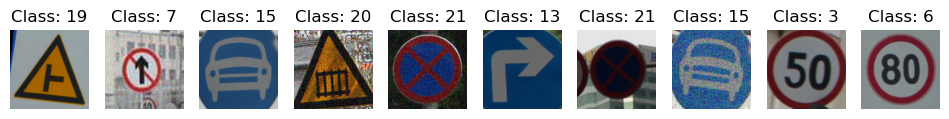

In [4]:
num_samples = 10  # Number of images to display
random_indices = random.sample(range(len(X_train)), num_samples)
#random_indices = np.size(random.sample(range(len(X_train)), 1))
#print(random_indices)
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_train[idx])  # Show image
    plt.title(f"Class: {y_train[idx]}")
    plt.axis("off")

plt.show()


In [55]:
test_folder = "Test"  # Replace with actual test folder name
test_images = []
test_labels = []

for img_file in os.listdir(test_folder):
    if img_file.endswith(".png"):
        img_path = os.path.join(test_folder, img_file)
        img = Image.open(img_path).convert("RGB")

        class_label = int(img_file.split("__")[0])

        # Preprocessing: only clean, no augmentation
        img = auto_crop(img)  # Optional but keeps it consistent
        img = resize_image(img, target_size)
        img = np.array(img) / 255.0  # Normalize to [0, 1]

        test_images.append(img)
        test_labels.append(class_label)

X_test = np.array(test_images)
y_test = np.array(test_labels)

# this is my test data


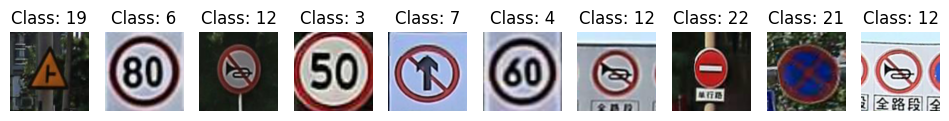

In [122]:
num_samples = 10
random_indices = random.sample(range(len(X_test)), num_samples)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Class: {y_test[idx]}")
    plt.axis("off")

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy

batch_size = 64

# Defining device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # mps if using mac gpu, else use cpu

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


NameError: name 'X_test' is not defined

In [6]:
input_size = 224*224
output_size = len(np.unique(y_train)) #number of classes=24

class CNN(nn.Module):
    def __init__(self, input_size, n_features, output_size): #n_features = number of filters (feature maps)
        super(CNN, self).__init__()
        self.n_features = n_features
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_features, kernel_size=5) # input channel = 3 to allow for rgb image, update kernel size accordingly based on the input size
        self.conv2 = nn.Conv2d(n_features, n_features, kernel_size=5)
        self.fc1 = nn.Linear(n_features*53*53, 50)
        self.fc2 = nn.Linear(50, output_size) #adjust input and output variables accordingly

    def forward(self, x):
        x = self.conv1(x) 
        x = F.relu(x) #using relu activation fn
        x = F.max_pool2d(x, kernel_size=2) # to downside the output (IF NEEDED since we doubled it jn)
        x = self.conv2(x) 
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_features*53*53) #flattens the multi-dimensional output from the convolutional and pooling layers into a 1D vector to feed into fc layers
        x = self.fc1(x) #fully connected layers at the end
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1) #apply log soft max to the output
        return x



In [7]:
# Variables for our model
# (TO BE ADJUSTED BASED ON HOW WE WANT TO TRAIN THE MODEL)
n_features = 32
learning_rate = 0.001
num_epochs = 20

In [8]:
# Initialising the CNN model 
model = CNN(input_size=224, n_features = n_features, output_size=24)
model = model.to(device)

# Set Loss function with criterion (can change i think)
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer (can change) 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


In [9]:
# TRAINING 

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

# Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        # Calculate accuracy by calculating loss against predicted loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    #store losses and accuracy in train_losses and train_accuracies
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - " f"Train Loss: {avg_train_loss:.4f} - Train Acc: {train_accuracy:.2f}%")

Epoch [1/20] - Train Loss: 3.0167 - Train Acc: 14.58%
Epoch [2/20] - Train Loss: 2.3928 - Train Acc: 34.66%
Epoch [3/20] - Train Loss: 1.5173 - Train Acc: 56.70%
Epoch [4/20] - Train Loss: 1.0044 - Train Acc: 72.07%
Epoch [5/20] - Train Loss: 0.8075 - Train Acc: 75.74%
Epoch [6/20] - Train Loss: 0.5647 - Train Acc: 83.78%
Epoch [7/20] - Train Loss: 0.4756 - Train Acc: 86.95%
Epoch [8/20] - Train Loss: 0.3741 - Train Acc: 88.72%
Epoch [9/20] - Train Loss: 0.3443 - Train Acc: 90.09%
Epoch [10/20] - Train Loss: 0.2638 - Train Acc: 92.94%
Epoch [11/20] - Train Loss: 0.2169 - Train Acc: 93.62%
Epoch [12/20] - Train Loss: 0.1863 - Train Acc: 95.16%
Epoch [13/20] - Train Loss: 0.1746 - Train Acc: 94.83%
Epoch [14/20] - Train Loss: 0.1324 - Train Acc: 96.47%
Epoch [15/20] - Train Loss: 0.1019 - Train Acc: 97.61%
Epoch [16/20] - Train Loss: 0.0778 - Train Acc: 98.20%
Epoch [17/20] - Train Loss: 0.0566 - Train Acc: 98.72%
Epoch [18/20] - Train Loss: 0.0528 - Train Acc: 98.95%
Epoch [19/20] - Tra

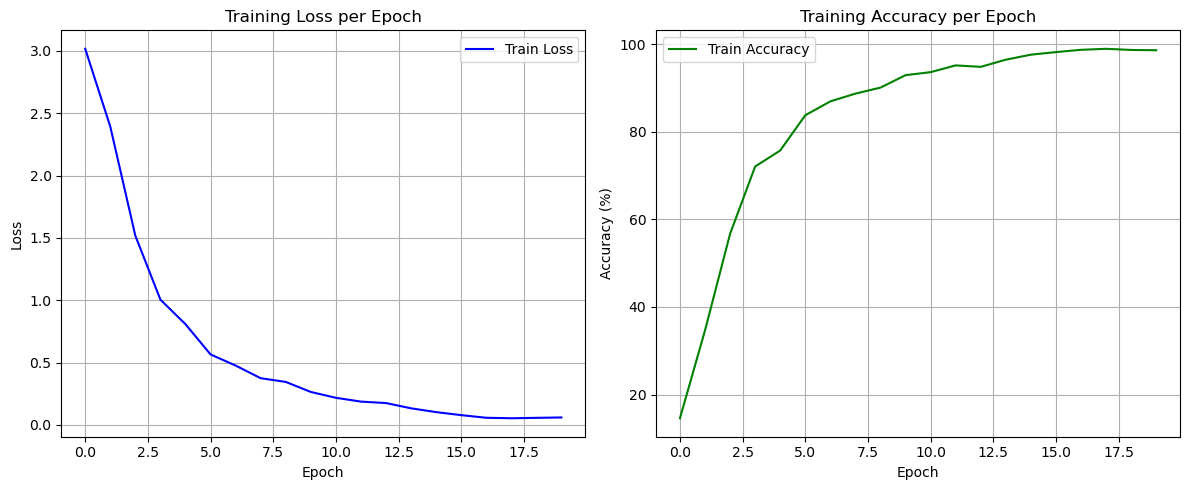

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", color="blue")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color="green")
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# TESTING 
with torch.no_grad():
    correct = 0
    total = 0
    test_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()  

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

    
print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

NameError: name 'test_loader' is not defined